<a href="https://colab.research.google.com/github/abdul-coder/crypto/blob/master/Welcome_To_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EEG confusion Prediction

EEG student confusion prediction

Given EEG data from students during MOOC lectures, let's try to predict whether a given student will be confused during a lecture.

We will use a Keras/TensorFlow neural network to make our predictions.

In [90]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [91]:
eeg_df = pd.read_csv('EEG_data.csv')
info_df = pd.read_csv('demographic_info.csv')

In [92]:
eeg_df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [93]:
info_df.head()

,subject ID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


##Merge the data

In [94]:
info_df.rename(columns={'subject ID': 'SubjectID'}, inplace=True)

data = info_df.merge(eeg_df, on='SubjectID')

In [95]:
data.head()

,SubjectID,age,ethnicity,gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0,25,Han Chinese,M,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0,25,Han Chinese,M,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0,25,Han Chinese,M,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0,25,Han Chinese,M,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0,25,Han Chinese,M,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0


In [96]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SubjectID           12811 non-null  int64  
 1    age                12811 non-null  int64  
 2    ethnicity          12811 non-null  object 
 3    gender             12811 non-null  object 
 4   VideoID             12811 non-null  float64
 5   Attention           12811 non-null  float64
 6   Mediation           12811 non-null  float64
 7   Raw                 12811 non-null  float64
 8   Delta               12811 non-null  float64
 9   Theta               12811 non-null  float64
 10  Alpha1              12811 non-null  float64
 11  Alpha2              12811 non-null  float64
 12  Beta1               12811 non-null  float64
 13  Beta2               12811 non-null  float64
 14  Gamma1              12811 non-null  float64
 15  Gamma2              12811 non-null  float64
 16  pred

## Cleaning the data

In [97]:
data = data.drop(['SubjectID', 'VideoID', 'predefinedlabel'], axis=1)

In [98]:
data.columns

Index([' age', ' ethnicity', ' gender', 'Attention', 'Mediation', 'Raw',
       'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1',
       'Gamma2', 'user-definedlabeln'],
      dtype='object')

In [99]:
data.rename(columns={' age': 'Age', ' ethnicity': 'Ethnicity',  ' gender':'Gender', 'user-definedlabeln': 'Label'}, inplace=True)

In [100]:
data.head()

,Age,Ethnicity,Gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label
0,25,Han Chinese,M,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,25,Han Chinese,M,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,25,Han Chinese,M,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0
3,25,Han Chinese,M,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0
4,25,Han Chinese,M,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0


In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12811 entries, 0 to 12810
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        12811 non-null  int64  
 1   Ethnicity  12811 non-null  object 
 2   Gender     12811 non-null  object 
 3   Attention  12811 non-null  float64
 4   Mediation  12811 non-null  float64
 5   Raw        12811 non-null  float64
 6   Delta      12811 non-null  float64
 7   Theta      12811 non-null  float64
 8   Alpha1     12811 non-null  float64
 9   Alpha2     12811 non-null  float64
 10  Beta1      12811 non-null  float64
 11  Beta2      12811 non-null  float64
 12  Gamma1     12811 non-null  float64
 13  Gamma2     12811 non-null  float64
 14  Label      12811 non-null  float64
dtypes: float64(12), int64(1), object(2)
memory usage: 1.6+ MB


In [102]:
data['Label'] = data['Label'].astype('int')

In [103]:
print("Missing Values:", data.isna().sum().sum())

Missing Values: 0


##Encoding features

In [104]:
data['Gender'].unique()

array(['M', 'F'], dtype=object)

In [105]:
data['Gender'] = data['Gender'].apply(lambda x: 1 if x == 'M' else 0)

In [106]:
data['Ethnicity'].unique()

array(['Han Chinese', 'English', 'Bengali'], dtype=object)

In [107]:
ethnicity_dummies = pd.get_dummies(data['Ethnicity'])
data = pd.concat([data, ethnicity_dummies], axis=1)
data = data.drop(['Ethnicity'], axis=1)

In [108]:
data.head()

,Age,Gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label,Bengali,English,Han Chinese
0,25,1,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0,0,0,1
1,25,1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0,0,0,1
2,25,1,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0,0,0,1
3,25,1,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0,0,0,1
4,25,1,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0,0,0,1


In [109]:
print("Non-numeric columns:", len(data.select_dtypes('object').columns))

Non-numeric columns: 0


##EDA

In [110]:
data.dtypes

Age              int64
Gender           int64
Attention      float64
Mediation      float64
Raw            float64
Delta          float64
Theta          float64
Alpha1         float64
Alpha2         float64
Beta1          float64
Beta2          float64
Gamma1         float64
Gamma2         float64
Label            int64
Bengali          uint8
English          uint8
Han Chinese      uint8
dtype: object

In [111]:
features = data.drop('Label', axis=1).copy()
num_features = len(features.columns)

print("Num of fetures:", num_features)

Num of fetures: 16


In [112]:
categorical_features = ['Age', 'Gender', 'Bengali', 'English', 'Han Chinese']

continuous_features = ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']

print("Categorical Features:", len(categorical_features))
print("Continuous Features:", len(continuous_features))

Categorical Features: 5
Continuous Features: 11


###UNivariate Analysis

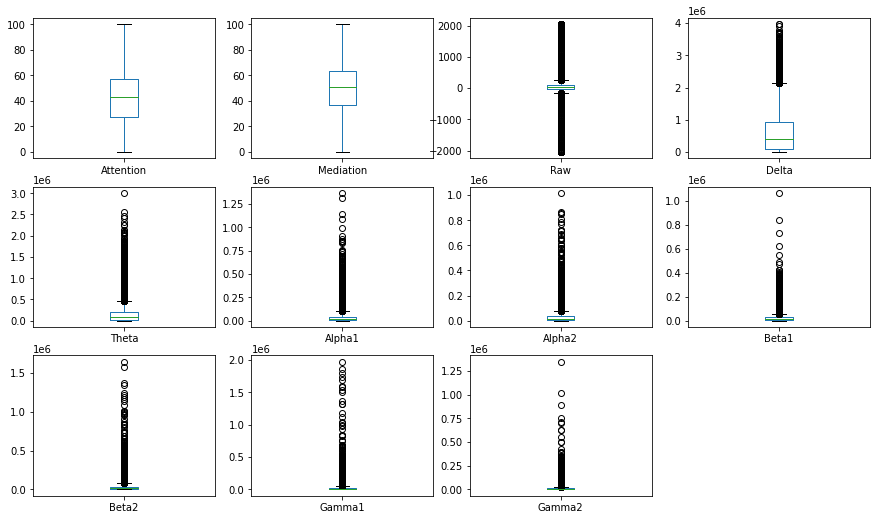

In [113]:
features[continuous_features].plot(kind='box', figsize=(15,15), subplots=True, layout=(5,4))
plt.show()

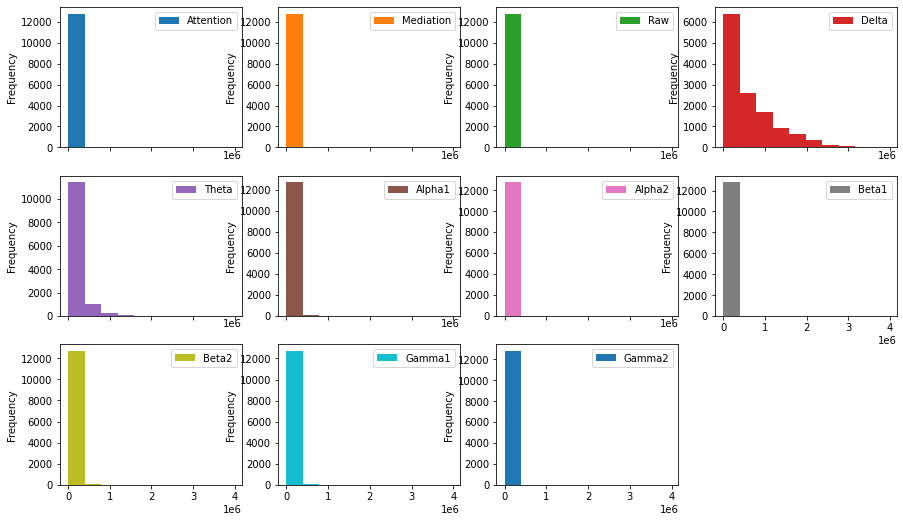

In [114]:
features[continuous_features].plot(kind='hist', figsize=(15,15), subplots=True, layout=(5,4))
plt.show()

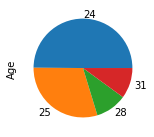

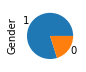

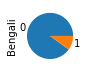

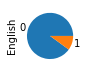

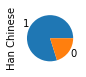

In [115]:
plt.figure(figsize=(20,5))
for feature in categorical_features:
  plt.subplot(2, 5,categorical_features.index(feature)+1)
  features[feature].value_counts().plot(kind='pie')
  plt.show()

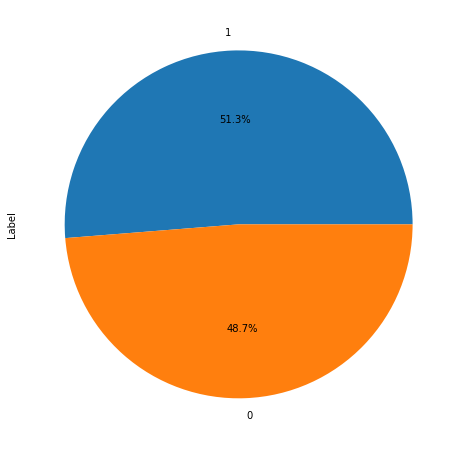

In [116]:
plt.figure(figsize=(8, 8))
data['Label'].value_counts().plot(kind='pie', autopct='%0.1f%%')
plt.show()

##Multivariate Analysis

<Figure size 1440x1440 with 0 Axes>

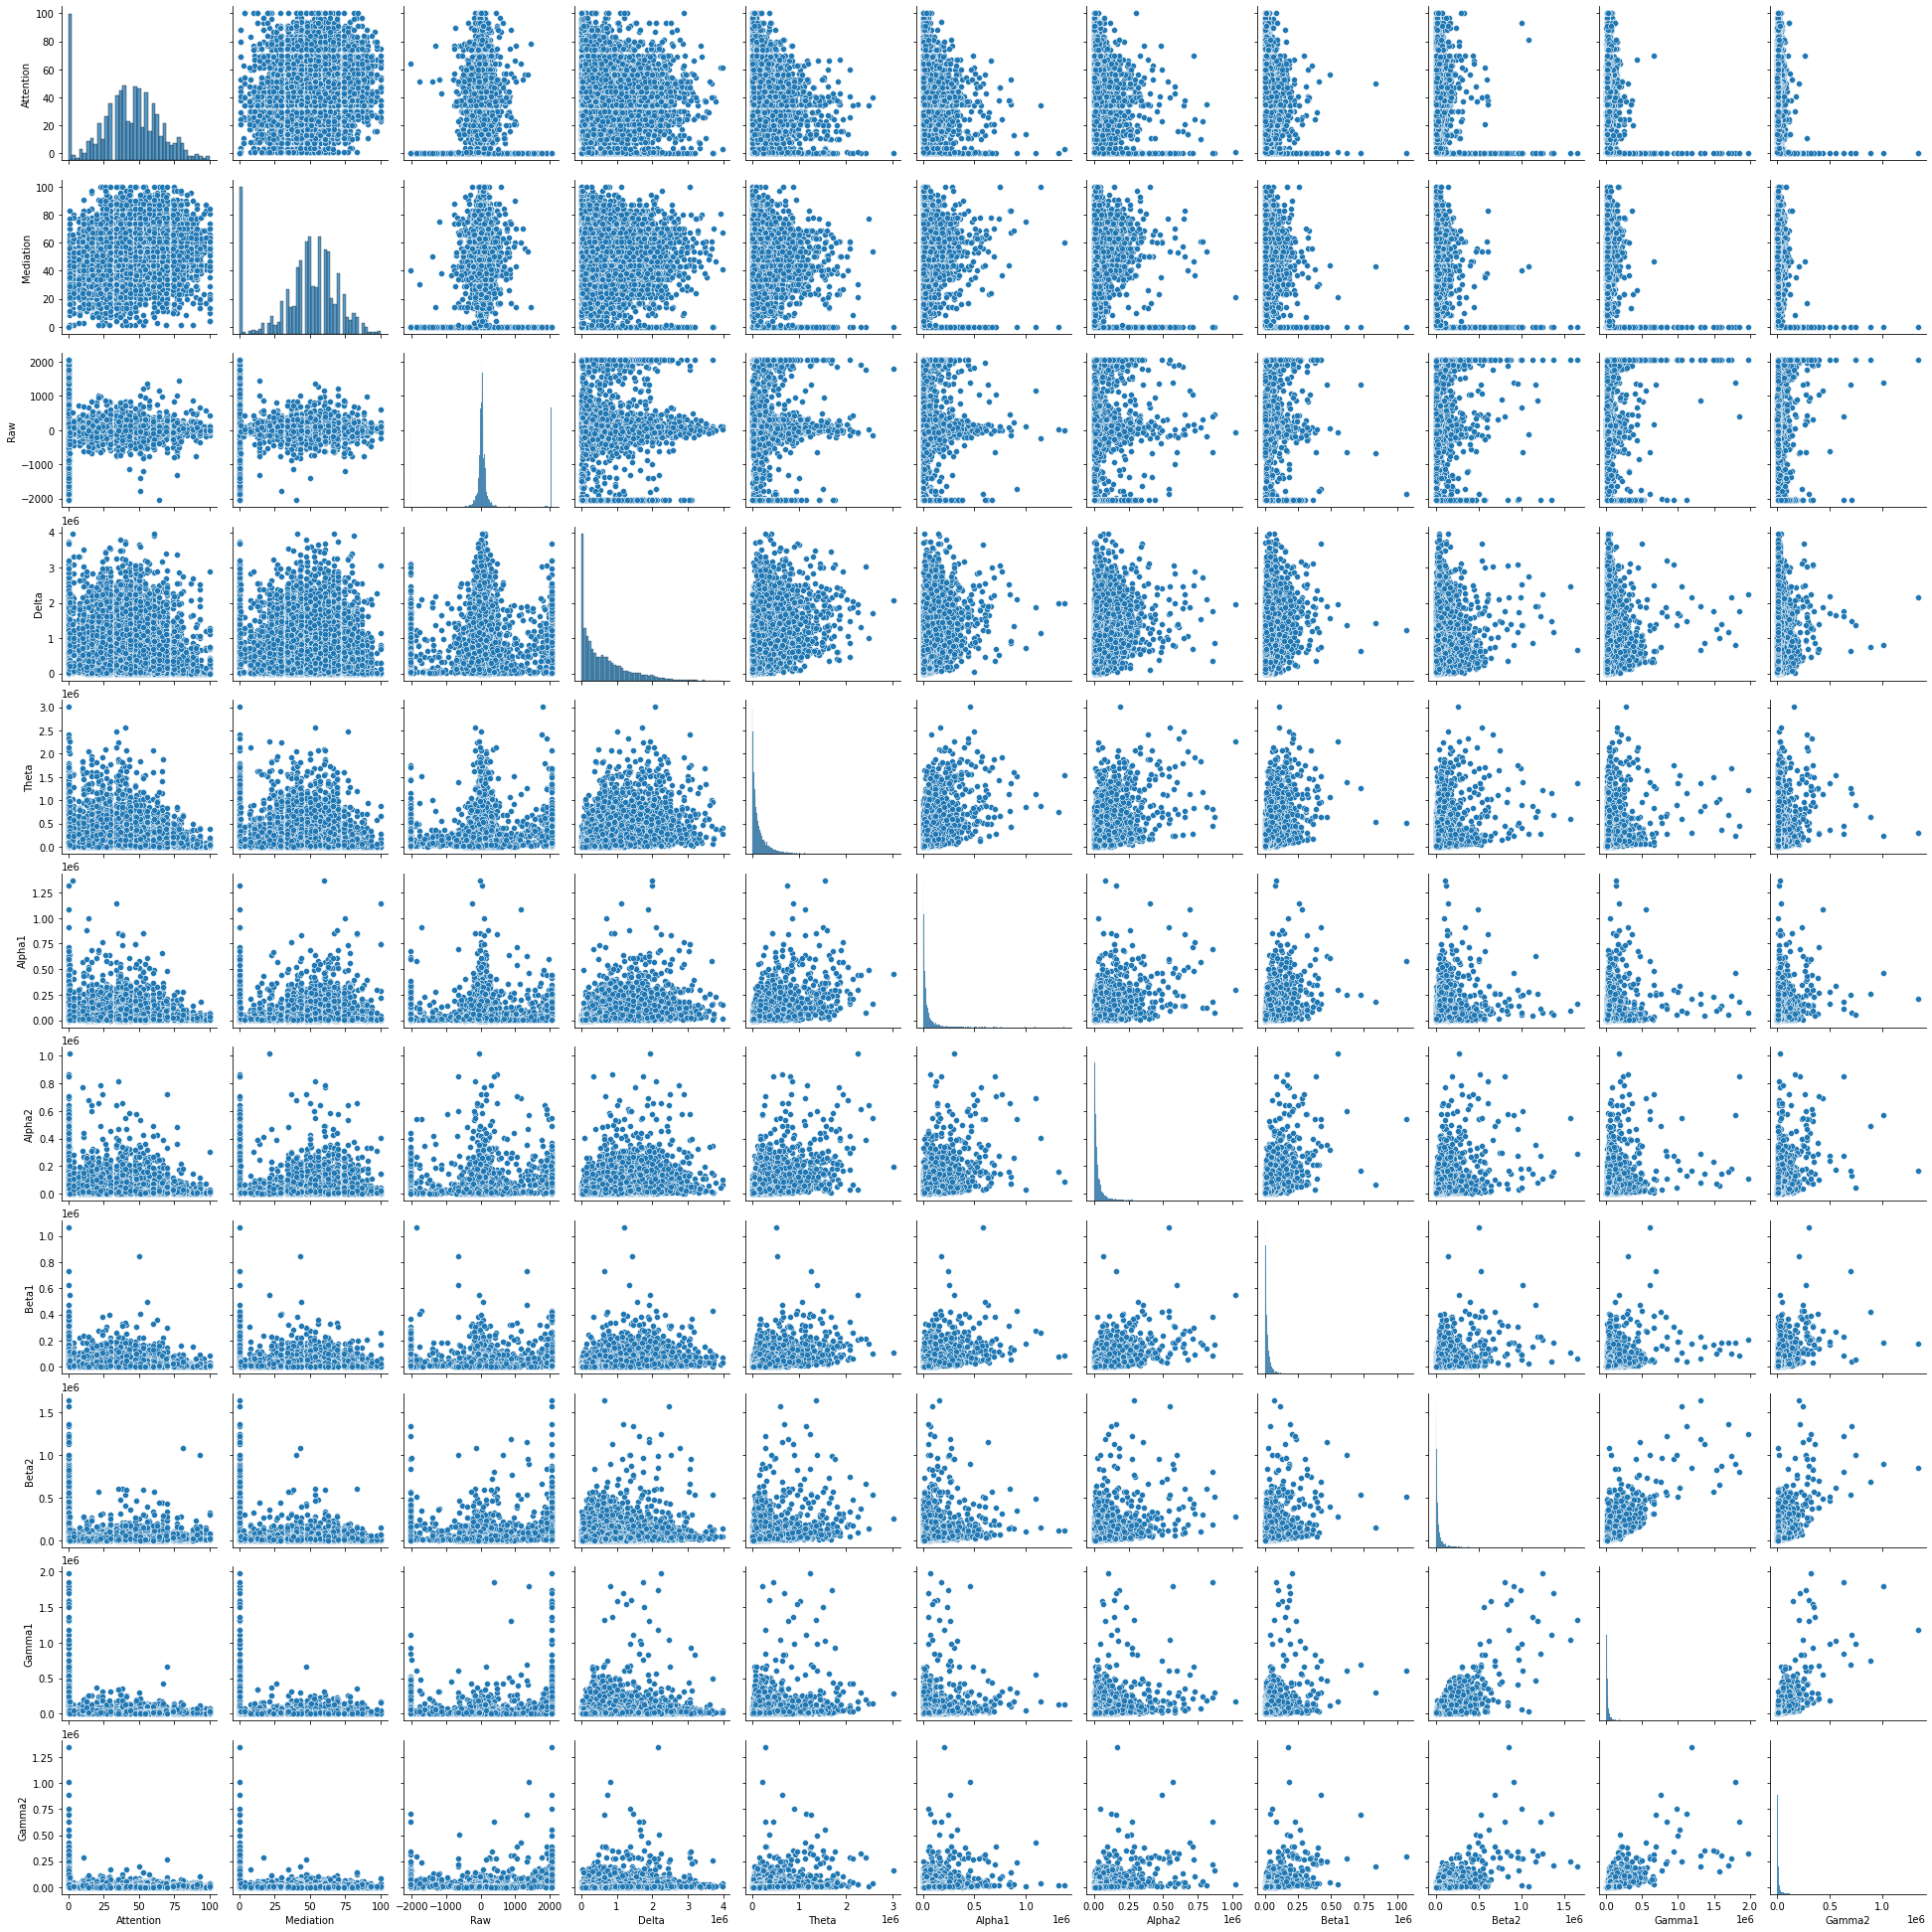

In [117]:
plt.figure(figsize=(20, 20))
sns.pairplot(features[continuous_features])
plt.show()

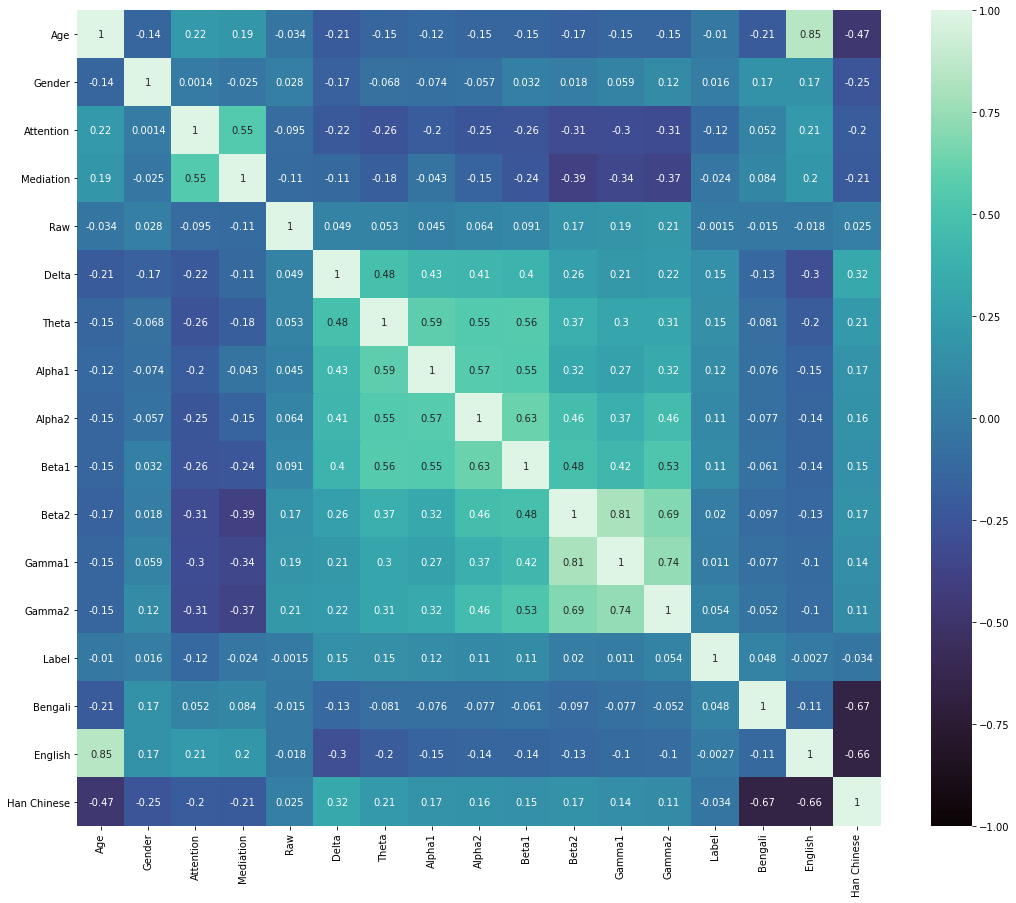

In [118]:
corr = data.corr()

plt.figure(figsize=(18, 15))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap='mako')
plt.show()

## Splitting and Scaling

In [119]:
data.head()

,Age,Gender,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label,Bengali,English,Han Chinese
0,25,1,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0,0,0,1
1,25,1,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0,0,0,1
2,25,1,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0,0,0,1
3,25,1,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0,0,0,1
4,25,1,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0,0,0,1


In [120]:
y = data['Label'].copy()
X = data.drop('Label', axis=1).copy()

In [121]:
scaler = StandardScaler()

X = scaler.fit_transform(X)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

##Training

In [129]:
inputs = tf.keras.Input(shape=(X_train.shape[1]))
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer='adam', 
    loss = 'binary_crossentropy', 
    metrics = [
               'accuracy', 
               tf.keras.metrics.AUC(name='auc')
    ]
)

batch_size = 32
epochs = 50

history = model.fit(X_train, 
                    y_train, 
                    validation_split=0.2, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[
                               tf.keras.callbacks.ReduceLROnPlateau()
                    ]
)

Epoch 1/50
225/225 [==============================] - 1s 3ms/step - loss: 0.6558 - accuracy: 0.6122 - auc: 0.6561 - val_loss: 0.6415 - val_accuracy: 0.6332 - val_auc: 0.6897
Epoch 2/50
225/225 [==============================] - 1s 2ms/step - loss: 0.6361 - accuracy: 0.6367 - auc: 0.6878 - val_loss: 0.6356 - val_accuracy: 0.6338 - val_auc: 0.6990
Epoch 3/50
225/225 [==============================] - 1s 2ms/step - loss: 0.6242 - accuracy: 0.6533 - auc: 0.7081 - val_loss: 0.6300 - val_accuracy: 0.6366 - val_auc: 0.7043
Epoch 4/50
225/225 [==============================] - 1s 2ms/step - loss: 0.6169 - accuracy: 0.6601 - auc: 0.7151 - val_loss: 0.6355 - val_accuracy: 0.6405 - val_auc: 0.7008
Epoch 5/50
225/225 [==============================] - 1s 2ms/step - loss: 0.6117 - accuracy: 0.6596 - auc: 0.7214 - val_loss: 0.6272 - val_accuracy: 0.6427 - val_auc: 0.7022
Epoch 6/50
225/225 [==============================] - 1s 2ms/step - loss: 0.6029 - accuracy: 0.6720 - auc: 0.7331 - val_loss: 0.61

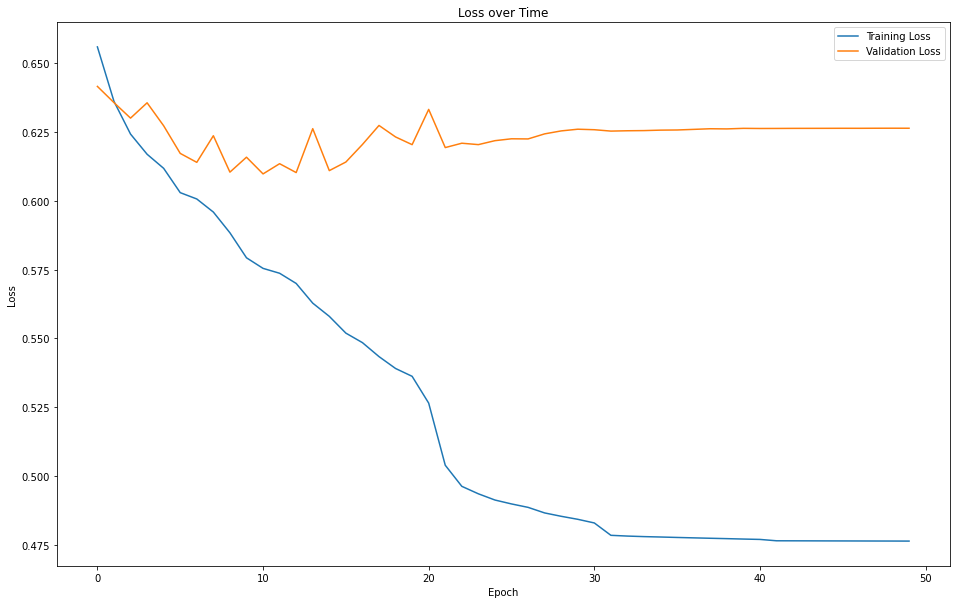

In [131]:
plt.figure(figsize=(16, 10))
plt.plot(range(epochs), history.history['loss'], label="Training Loss")
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Time")
plt.legend()

plt.show()

In [132]:
model.evaluate(X_test, y_test)

121/121 [==============================] - 0s 1ms/step - loss: 0.6251 - accuracy: 0.6829 - auc: 0.7483


[0.6250927448272705, 0.6828824281692505, 0.7483237385749817]

In [133]:
y_true = np.array(y_test)

y_pred = np.squeeze(model.predict(X_test))
y_pred = np.array(y_pred >= 0.5, dtype=np.int)

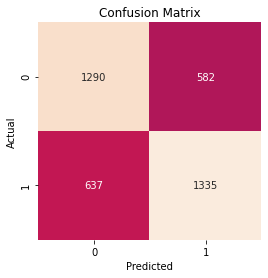

In [135]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cbar=False)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

In [136]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1872
           1       0.70      0.68      0.69      1972

    accuracy                           0.68      3844
   macro avg       0.68      0.68      0.68      3844
weighted avg       0.68      0.68      0.68      3844

